# **Clustering con PCA + RandomForest**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score


## **Descarga del Dataset original**

Para descargar el dataset a Colab, es necesario subir su Kaggle API Key personal (para crear una nueva, revise la sección Authentication en https://www.kaggle.com/docs/api).

Suba a continuación el archivo `.json` generado.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"daniellujanagudelo","key":"e0f7fc0287fd836756e720097ec0469f"}'}

In [ ]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c home-credit-default-risk

 99% 681M/688M [00:07<00:00, 95.9MB/s]
100% 688M/688M [00:07<00:00, 101MB/s] 


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/home-credit-default-risk.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## **Preprocesamiento**

La siguiente función realiza todo el preprocesamiento necesario a los datos, explicado en [01 - Preprocesamiento.ipynb](https://colab.research.google.com/drive/1w9a0auNVqZ2hN_urrf3rmJ-3gVfDUBx0#scrollTo=2c5ymp78xowc)

In [ ]:
def preprocess_data(data: pd.DataFrame, test_data: pd.DataFrame):
    def fill_nan_with_mode(column):
        mode = column.mode()[0]
        return column.fillna(mode)
    data = data.fillna(data.mean()).apply(fill_nan_with_mode, axis=0)
    test_data = test_data.fillna(test_data.mean()).apply(fill_nan_with_mode, axis=0)
    cat_columns = data.select_dtypes(include=["object"])
    data_encoded = pd.get_dummies(data, columns=cat_columns.columns)
    test_data_encoded = pd.get_dummies(test_data, columns=cat_columns.columns)

    return data_encoded, test_data_encoded

data, test_data = preprocess_data(pd.read_csv("/content/application_train.csv"), pd.read_csv("/content/application_test.csv"))

<ipython-input-6-c319868e6578>:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.fillna(data.mean()).apply(fill_nan_with_mode, axis=0)
<ipython-input-6-c319868e6578>:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_data = test_data.fillna(test_data.mean()).apply(fill_nan_with_mode, axis=0)


In [ ]:
X_train = data.drop("TARGET", axis=1)
y_train = data["TARGET"]
for col in X_train.columns.difference(test_data.columns):
    test_data[col] = [0] * len(test_data)

test_data = test_data[X_train.columns]

## **Reducción de dimensionalidad usando PCA**

### **Mejores parámetros para PCA**

In [ ]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('classifier', RandomForestClassifier())
])

param_grid = {
    'pca__n_components': [5, 10, 20],
    'classifier__n_estimators': [100], # Obtenido de 02 - Modelo con Random Forest.ipynb
    'classifier__max_depth': [20] # Obtenido de 02 - Modelo con Random Forest.ipynb
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [20],
                         'classifier__n_estimators': [100],
                         'pca__n_components': [5, 10, 20]},
             scoring='accuracy')

In [ ]:
grid_search.best_params_

{'classifier__max_depth': 20,
 'classifier__n_estimators': 100,
 'pca__n_components': 20}

## **Predicción con el mejor modelo**

In [ ]:
y_pred = grid_search.best_estimator_.predict_proba(test_data)

In [ ]:
y_pred

array([[0.94663901, 0.05336099],
       [0.83663856, 0.16336144],
       [0.89932821, 0.10067179],
       ...,
       [0.86631808, 0.13368192],
       [0.85993819, 0.14006181],
       [0.77351215, 0.22648785]])

In [ ]:
df = pd.DataFrame()
df["SK_ID_CURR"] = test_data["SK_ID_CURR"]
df["TARGET"] = y_pred[:, 1]
df = df.set_index("SK_ID_CURR")
df.to_csv("results.csv")

## **Resultados**

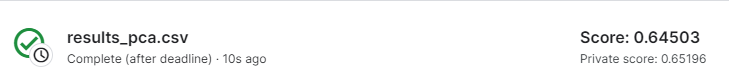

## **Curva de aprendizaje**

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train, cv=2, n_jobs=-1, train_sizes=[0.1, 0.35, 0.6, 1.0]
)

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

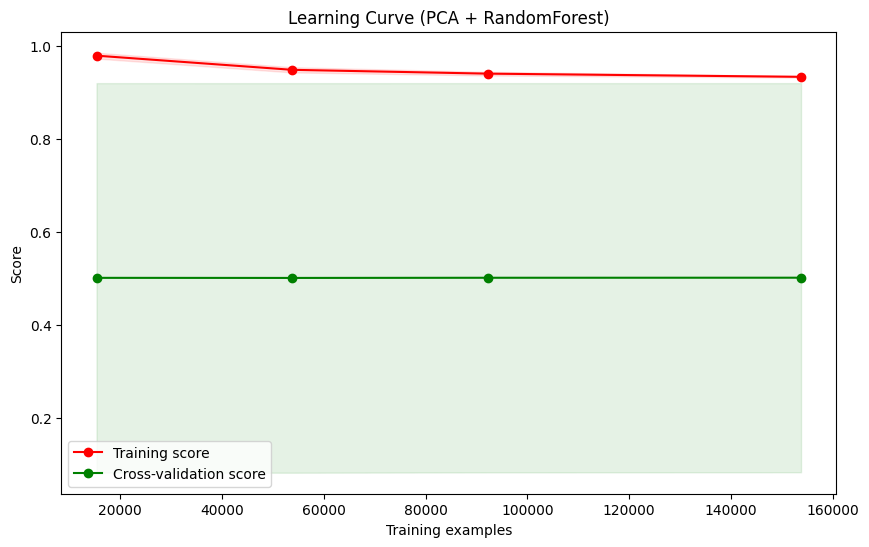

In [ ]:
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve (PCA + RandomForest)")
plt.show()